In [27]:
using Distributions
using Plots
using DataStructures
using Random
using LinearAlgebra
using HDF5
using StatsBase

using QuantumMonteCarlo

a = 1.0
reference_energy = -0.424
exact_energy = -0.5

#include("forceutil.jl")

# DMC settings
τ = 1e-2
nwalkers = 100
num_blocks = 2000
steps_per_block = Int64(1/τ)
neq = 10
α = 0.283

# Trial wave function
function ψ1s(x::Array{Float64})
    exp(-α*norm(x)^2)
end

ψtrial = WaveFunction(
    ψ1s,
    x -> gradient_fd(ψ1s, x),
    x -> laplacian_fd(ψ1s, x)
    #x -> -2α*x*ψ1s(x),
    #x -> 2α*ψ1s(x)*(2α*norm(x)^2 - 3.0)
)

# Setting up the hamiltonian
hamiltonian(ψstatus, x) = -0.5*ψstatus.laplacian - 1/norm(x)*ψstatus.value
hamiltonian_recompute(ψ, x) = -0.5*ψ.laplacian(x) - 1/norm(x)*ψ.value(x)

model = Model(
    hamiltonian,
    hamiltonian_recompute,
    ψtrial,
)

rng = MersenneTwister(0)

# create "Fat" walkers
walkers = QuantumMonteCarlo.generate_walkers(nwalkers, ψtrial, rng, Normal(0, 1), 3)
fat_walkers = [QuantumMonteCarlo.FatWalker(walker, OrderedDict()) for walker in walkers]

### Actually run DMC
energies, errors = QuantumMonteCarlo.run_dmc!(
    model, 
    fat_walkers, 
    τ, 
    num_blocks, 
    steps_per_block, 
    reference_energy; 
    rng=rng, 
    neq=neq, 
    verbosity=:progressbar
);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:50


In [28]:
println("Energy: $(last(energies)) +- $(last(errors))")

Energy: -0.49981840123087506 +- 0.0028568255370530924


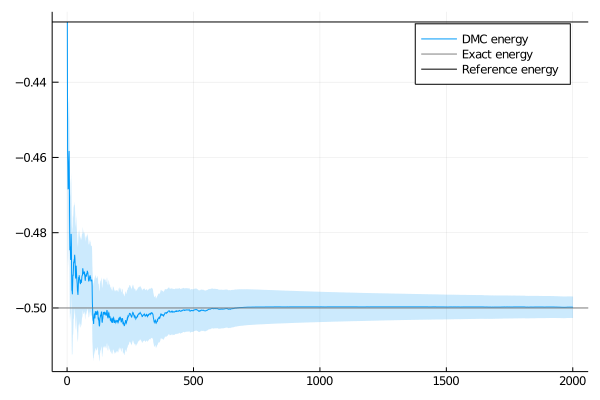

In [29]:
plot(energies, ribbon=(errors, errors), fillalpha=0.2, label="DMC energy")
hline!([exact_energy], color="grey", labels="Exact energy")
hline!([reference_energy], color="black", labels="Reference energy")